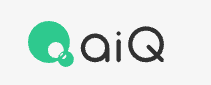

[disclaimer](./disclaimer.txt/)

# alternative data evaluation for multiple datasets 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Definitions
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html == True:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

from aiq_strategy_robot.data.data_accessor import DAL
from utils.shortcut import multi_dataset as sc

In [3]:
sdh = DAL()

## Data Load & Transfomation
In this section, all data are labeled with the earliest date that can be obtained.

### Data Load

Retrieve each factor and register it to `handler`.
> In this sample, retrieval and registration operations are omitted.

In [4]:
sdh.extract.clear()

# dfsyms = sc.load_symbols()
# list_figis = dfsyms['FIGI'].unique().tolist()
# list_tickers = dfsyms['TICKER'].unique().tolist()

# Load POS Data
data_id_pos = sc.register_pos_data(sdh)
display(sdh.get_raw_data(data_id_pos).tail())

# Price Data (origin: FactSet HTTP API)
data_id_price = sc.register_market_prices(sdh)
display(sdh.get_raw_data(data_id_price).tail())


# TruValue data (origin: FactSet Snowflake)
data_id_tv = sc.register_tv(sdh)
display(sdh.get_raw_data(data_id_tv).tail())

# Quants factors
data_id_f266 = sc.register_quants_factors(sdh)
display(sdh.get_raw_data(data_id_f266).tail())



pos_sales     share  unit_price  unit_price_vs_ind
ticker  datetime                                                      
9997-JP 2024-02-08   0.012324  0.000572    0.691312           0.493701
        2024-02-15   0.005229  0.000243    0.829920           0.575624
        2024-02-22   0.008494  0.000395    0.813988           0.557915
        2024-02-29   0.006700  0.000317    0.768075           0.509813
        2024-03-07   0.008056  0.000368    0.798211           0.560644

fsymId  TICKER_REGION    volume   open   high    low  \
ticker  datetime                                                             
9997-JP 2023-10-27  BT5ZHY-R           9997  290300.0  622.0  628.0  622.0   
        2023-10-30  BT5ZHY-R           9997  409300.0  622.0  625.0  607.0   
        2023-10-31  BT5ZHY-R           9997  528300.0  610.0  613.0  604.0   
        2023-11-01  BT5ZHY-R           9997  421200.0  627.0  633.0  619.0   
        2023-11-02  BT5ZHY-R           9997  323800.0  631.0  631.0  621.0   

                    close currency  
ticker  datetime                    
9997-JP 2023-10-27  626.0      JPY  
        2023-10-30  612.0      JPY  
        2023-10-31  612.0      JPY  
        2023-11-01  628.0      JPY  
        2023-11-02  628.0      JPY

MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  \
ticker  datetime                                                    
9997-JP 2023-11-16                    64.42                 40.63   
        2023-11-17                    64.41                 40.35   
        2023-11-18                    64.40                 40.28   
        2023-11-19                    64.35                 40.37   
        2023-11-20                    64.40                 40.23   

                    ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
ticker  datetime                                                         
9997-JP 2023-11-16                       76.55               76.545724   
        2023-11-17                       76.56               76.564881   
        2023-11-18                       76.58               76.583965   
        2023-11-19                       76.60               76.602976   
        2023-11-20                       76.62               76.621916   

                    ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  
ticker  datetime                                                   
9997-JP 2023-11-16                81.457731               81.5853  
        2023-11-17                81.409830               81.5853  
        2023-11-18                81.362007               81.5853  
        2023-11-19                81.314263               81.5853  
        2023-11-20                81.266596               81.5853

mktVal  retMom252D         ey      roe        bp
ticker  datetime                                                        
9997-JP 2023-10-25  406.036593    -6.88040  13.298766  6.02091  2.208923
        2023-10-26  399.741141    -8.16547  13.506853  6.02091  2.243487
        2023-10-27  406.905111    -6.47612  13.269051  6.02091  2.203988
        2023-10-30  397.751893    -7.96944  13.574404  6.02091  2.254707
        2023-10-31  394.940619    -8.76623  14.265102  6.02091  2.238126

In [5]:
# Set Alias (Optional)
sdh.set_alias({
    data_id_price: 'FTech',
    data_id_f266: 'FFactor',
    data_id_pos: 'FPos',
    data_id_tv: 'FTV',
})

sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,ALTERNATIVE,aiq_pos_csmr_goods,Unknown,FPos,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[ticker, datetime]",2008-03-20 00:00:00,2024-03-07 00:00:00
2,RawData,FACTSET,gpd_prices,Unknown,FTech,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[ticker, datetime]",2016-01-04 00:00:00,2023-11-02 00:00:00
3,RawData,FACTSET,TrueValue,Unknown,FTV,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[ticker, datetime]",2016-01-01 00:00:00,2023-11-20 00:00:00
4,RawData,FACTSET,Quants factors,Unknown,FFactor,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[ticker, datetime]",2016-01-29 00:00:00,2023-10-31 00:00:00


### Transformations
> In this sample, detailed transformation operations are omitted.

In [6]:
# Make Features
resample_term = 'W-FRI'
baselines = sc.make_baseline(sdh, data_id_price, data_id_f266, data_id_tv, data_id_pos, X_shift=2, resample_term=resample_term)
FTV_MATERIALITY_ADJ_INSIGHT, *_ = baselines['FTV']
FPos_sales, FPos_share = baselines['FPos']

# Make return
open_return = sdh.transform.resample(
    data_id=data_id_price,
    fields='open',
    rule=resample_term,
    func='first',
    label='left',
    closed='left'
).dropna().log_diff(periods=1).multiply_by_scalar(value=100).variable_ids[-1]

In [7]:
sdh.transform.definition.tail()

,variable_id,data_id,category,data_source,table,variable_type,field,reference_id,method,params,process_id
variable_name,,,,,,,,,,,
Fpos_Share_MovePrevDay(Fri)_Resampled(W-FRI|last)_SMA(012)_Diff(052)_Shifted(002),40,1,RawData,ALTERNATIVE,Unknown,feature,None,38,shift,periods=2,c299a5e9
Ftech_Open_Resampled(W-FRI|first),41,2,RawData,FACTSET,Unknown,feature,open,None,resample,"rule=""W-FRI"", func=""first"", closed=""left"", lab...",85fcd5b0
Ftech_Open_Resampled(W-FRI|first)_Dropna(all),42,2,RawData,FACTSET,Unknown,feature,None,41,dropna,"how=""all""",b3e86c42
Ftech_Open_Resampled(W-FRI|first)_Dropna(all)_LogDiff(001),43,2,RawData,FACTSET,Unknown,feature,None,42,log_diff,periods=1,246f222e
Ftech_Open_Resampled(W-FRI|first)_Dropna(all)_LogDiff(001)_MultiplyBy(100),44,2,RawData,FACTSET,Unknown,feature,None,43,multiply_scalar,value=100,fc589f83


## Baseline

In [8]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

In [9]:
start_date = '2018-02-25'
end_date = '2023-10-27'


### backtesting by single data

In [10]:
dfqret, stats, dfsigqt = ade.q_backtest(
    FPos_sales,
    open_return,
    nq=4,
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    plot='Pos Sales Backtest'
)

Variables being created: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it]


,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-21.237549,-3.753852,14.805589,-0.253543,0.520270,3.323051,-45.328900,-0.082814
#2,-16.513333,-2.918822,15.642715,-0.186593,0.557432,6.124340,-51.734235,-0.056420
#3,-1.287699,-0.227608,14.997441,-0.015176,0.543919,6.166728,-35.756987,-0.006365
#4,11.866816,2.097524,15.025640,0.139596,0.547297,2.898221,-40.014148,0.052420
#4-#1,33.104365,5.851377,5.078135,1.152269,0.550676,6.221272,-6.554653,0.892706
#4-#1(cost),33.097325,5.850133,5.078125,1.152026,0.550676,6.221272,-6.555264,0.892433


In [11]:
dfqret, stats, dfsigqt = ade.q_backtest(
    FTV_MATERIALITY_ADJ_INSIGHT,
    open_return,
    nq=4,
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    plot='TruValue Insight Backtest'
)

/home/schiba/work/asr_protected/asr_protected/data_manager/transform/generator.py:350: UserWarning:

Differences exist in the y and X feature universe::{'2204-JP'}.Only use universe that exist in both.



,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-15.887676,-2.808233,17.439277,-0.161029,0.510135,2.686283,-40.115624,-0.070003
#2,-9.393714,-1.660390,15.609688,-0.106369,0.533784,6.695950,-46.888220,-0.035412
#3,-8.373479,-1.480058,15.950270,-0.092792,0.516892,6.123535,-47.515517,-0.031149
#4,11.221629,1.983484,17.756063,0.111707,0.543919,1.770595,-44.805311,0.044269
#4-#1,27.109306,4.791717,7.439300,0.644109,0.557432,4.456878,-17.114086,0.279987
#4-#1(cost),27.104263,4.790826,7.439323,0.643987,0.557432,4.456878,-17.116097,0.279902


### backtesting by multiple data

In [12]:
dfqret, stats, dfsigqt = ade.q_backtest(
    [FPos_sales, FTV_MATERIALITY_ADJ_INSIGHT],
    open_return,
    nq=[4, 4],
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    plot='Pos Sales * TruValue Insight Backtest'
)

/home/schiba/work/asr_protected/asr_protected/data_manager/transform/generator.py:350: UserWarning:

Differences exist in the y and X feature universe::{'2204-JP'}.Only use universe that exist in both.



,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-59.280516,-10.478154,17.769346,-0.589676,0.466216,6.586118,-75.261844,-0.139223
#2,-6.067183,-1.072408,16.267600,-0.065923,0.533784,11.519354,-43.165220,-0.024844
#3,-11.898913,-2.103198,16.493239,-0.127519,0.493243,11.558824,-42.180276,-0.049862
#4,-17.541475,-3.100551,18.959519,-0.163535,0.516892,6.858277,-50.732928,-0.061115
#5,-32.085794,-5.671339,20.179102,-0.281050,0.523649,10.094509,-53.364298,-0.106276
#6,-10.258745,-1.813289,17.692245,-0.102491,0.527027,17.131811,-58.529820,-0.030981
#7,-11.153381,-1.971421,18.431726,-0.106958,0.513514,16.780953,-56.615352,-0.034821
#8,3.905152,0.690257,20.507859,0.033658,0.550676,11.926216,-50.396993,0.013696
#9,-2.988993,-0.528321,19.392647,-0.027243,0.530405,12.311042,-39.789599,-0.013278
#10,-7.304739,-1.291152,17.417110,-0.074131,0.527027,18.257601,-48.391360,-0.026681


## Machine Learning


In [13]:
from aiq_strategy_robot.predictors import ScikitLearnPredictor

slp = ScikitLearnPredictor(sdh)
ade = AltDataEvaluator(sdh)

In [14]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.0001)

In [15]:
verbose=False

In [16]:
_baselines = []
[_baselines.extend(v) for v in baselines.values()]

[None, None, None, None]

### Prediction by Baseline
#### Model fitting and prediction.

In [17]:
pred_name = 'simple_prediction'

dfpred, dfstats = slp.predict_with_sliding_window(
    features=_baselines,
    objective=open_return,
    model=model,
    test_start='2021-02-26', 
    test_end='2023-10-27', 
    test_period=4*3,
    train_period=52*3,
    period_freq='W-FRI',
    min_train_sample=50,
    dropna=True,
    update_name=pred_name,
    verbose=verbose
)

/home/schiba/work/asr_protected/asr_protected/data_manager/transform/generator.py:350: UserWarning:

Differences exist in the y and X feature universe::{'2204-JP'}.Only use universe that exist in both.

Prediction running on a rolling period basis.: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


,rho,RMSE,MAE
Stats.,0.048336,3.316623,2.351579


##### Calculate the correlation between the prediction results and KIP.

In [18]:
rho_time = ade.compu_rho(pred_name, open_return, by='ticker', rename_features=[pred_name])
rho_time.T.xs('t-val', level=1).sort_values(pred_name, ascending=False).head()


Variables being created: 100%|██████████| 1/1 [00:00<00:00, 92.78it/s]


,simple_prediction
ticker,
3591-JP,3.672340
2931-JP,3.182385
4005-JP,2.915883
4574-JP,2.867035
4530-JP,2.795314


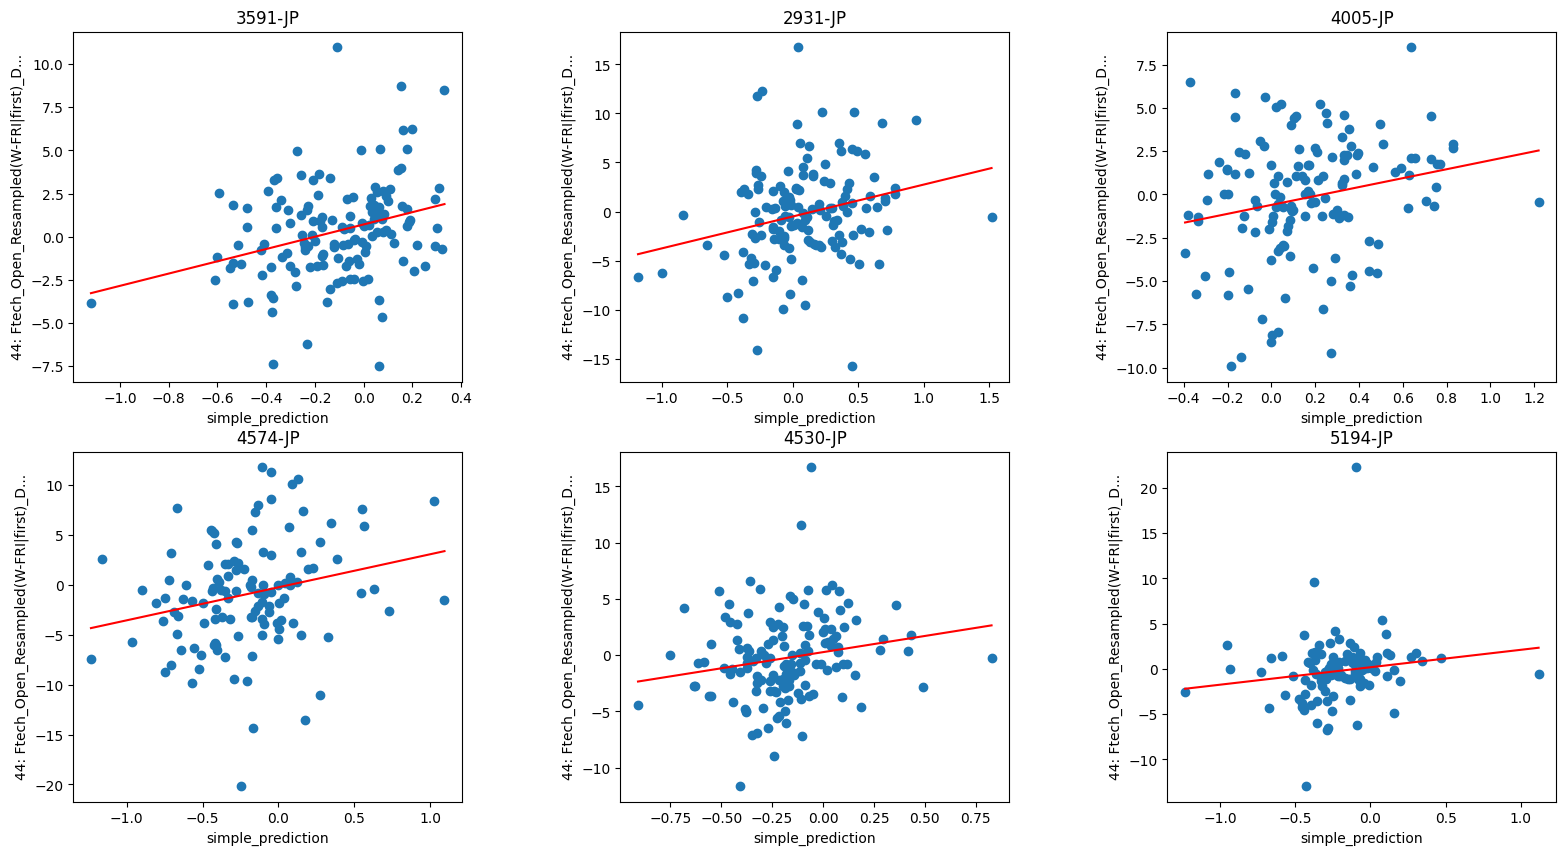

In [19]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values(pred_name, ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=pred_name,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=35,
)

##### Backtesting of predicted results as signals.

In [20]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pred_name,
    open_return,
    nq=3,
    fromd=start_date,
    tod=end_date,
    plot=f'Baseline Prediction-by-[{pred_name}] Backtest'
)

/home/schiba/work/asr_protected/asr_protected/data_manager/transform/generator.py:350: UserWarning:

Differences exist in the y and X feature universe::{'9941-JP', '3004-JP', '8005-JP', '4512-JP', '4925-JP', '2112-JP', '2108-JP', '2917-JP', '2612-JP', '4928-JP', '2117-JP', '7819-JP', '4551-JP', '2930-JP', '2003-JP', '2215-JP', '9852-JP', '2903-JP', '2816-JP', '2293-JP', '9713-JP', '3346-JP', '2224-JP', '2551-JP', '4956-JP', '2901-JP', '2733-JP', '2922-JP', '1380-JP', '2883-JP', '4931-JP', '1384-JP', '2700-JP', '8006-JP', '8041-JP', '4623-JP', '9260-JP', '4558-JP', '2222-JP', '2692-JP', '2218-JP', '2294-JP', '9385-JP', '9950-JP', '4998-JP', '2804-JP', '8030-JP', '2291-JP', '2722-JP', '2872-JP', '2207-JP', '2597-JP', '2819-JP', '6309-JP', '8095-JP', '8228-JP', '4974-JP', '2884-JP', '2009-JP', '3417-JP', '2286-JP', '2926-JP', '2877-JP', '7297-JP', '2204-JP', '2586-JP', '3540-JP', '3306-JP', '2813-JP', '3604-JP', '2217-JP', '2927-JP', '2058-JP', '2876-JP', '2919-JP', '4595-JP'}.Only use un

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-11.492259,-4.311074,9.746845,-0.442305,0.507143,17.920965,-26.735898,-0.161247
#2,0.910551,0.341573,11.794562,0.028960,0.521429,27.742789,-19.630834,0.017400
#3,15.225576,5.711547,14.237344,0.401167,0.550000,18.697680,-18.044163,0.316532
#3-#1,26.717835,10.022621,7.759106,1.291724,0.585714,36.618645,-4.736391,2.116088
#3-#1(cost),26.698312,10.015297,7.759091,1.290782,0.585714,36.618645,-4.737726,2.113946


#### Model fitting and prediction with pre-processing parameters　

In [21]:
pred_name = 'prediction_with_pre-processing'

dfpred, dfstats = slp.predict_with_sliding_window(
    features=_baselines,
    objective=open_return,
    model=model,
    test_start='2021-02-25', 
    test_end='2023-10-27', 
    test_period=4*3,
    train_period=52*3,
    period_freq= 'W-FRI',
    min_train_sample=50,
    
    # Main pre-treatment parameters.
    clip_q = 0.01,                # Quantile used for clipping features.
    q_cut_Y=False,                # Specifies whether to apply clipping to the objective (Y) as defined by `clip_q`
    normal_scaling='datetime',    # Type of normalization applied to features.
    normal_scaling_Y=False,       # Specifies whether to apply normalization to the objective (Y) as defined by `normal_scaling`
    impute_x=None,                # Specifies the method for imputing missing values in features. Ffill, KNN and Iterative can be specified.
    dropna=True,                  # If True, rows containing missing values will be dropped. Default is False.
    update_name=pred_name,
    verbose=verbose
)

/home/schiba/work/asr_protected/asr_protected/data_manager/transform/generator.py:350: UserWarning:

Differences exist in the y and X feature universe::{'2204-JP'}.Only use universe that exist in both.

Prediction running on a rolling period basis.: 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


,rho,RMSE,MAE
Stats.,0.041206,3.314102,2.34145


##### Calculate the correlation between the prediction results and KIP.

In [22]:
rho_time = ade.compu_rho(pred_name, open_return, by='ticker', rename_features=[pred_name])
rho_time.T.xs('t-val', level=1).sort_values(pred_name, ascending=False).head()

Variables being created: 100%|██████████| 1/1 [00:00<00:00, 102.51it/s]


,prediction_with_pre-processing
ticker,
3591-JP,2.818138
2001-JP,2.302890
4507-JP,2.216347
4188-JP,2.198325
2915-JP,2.136687


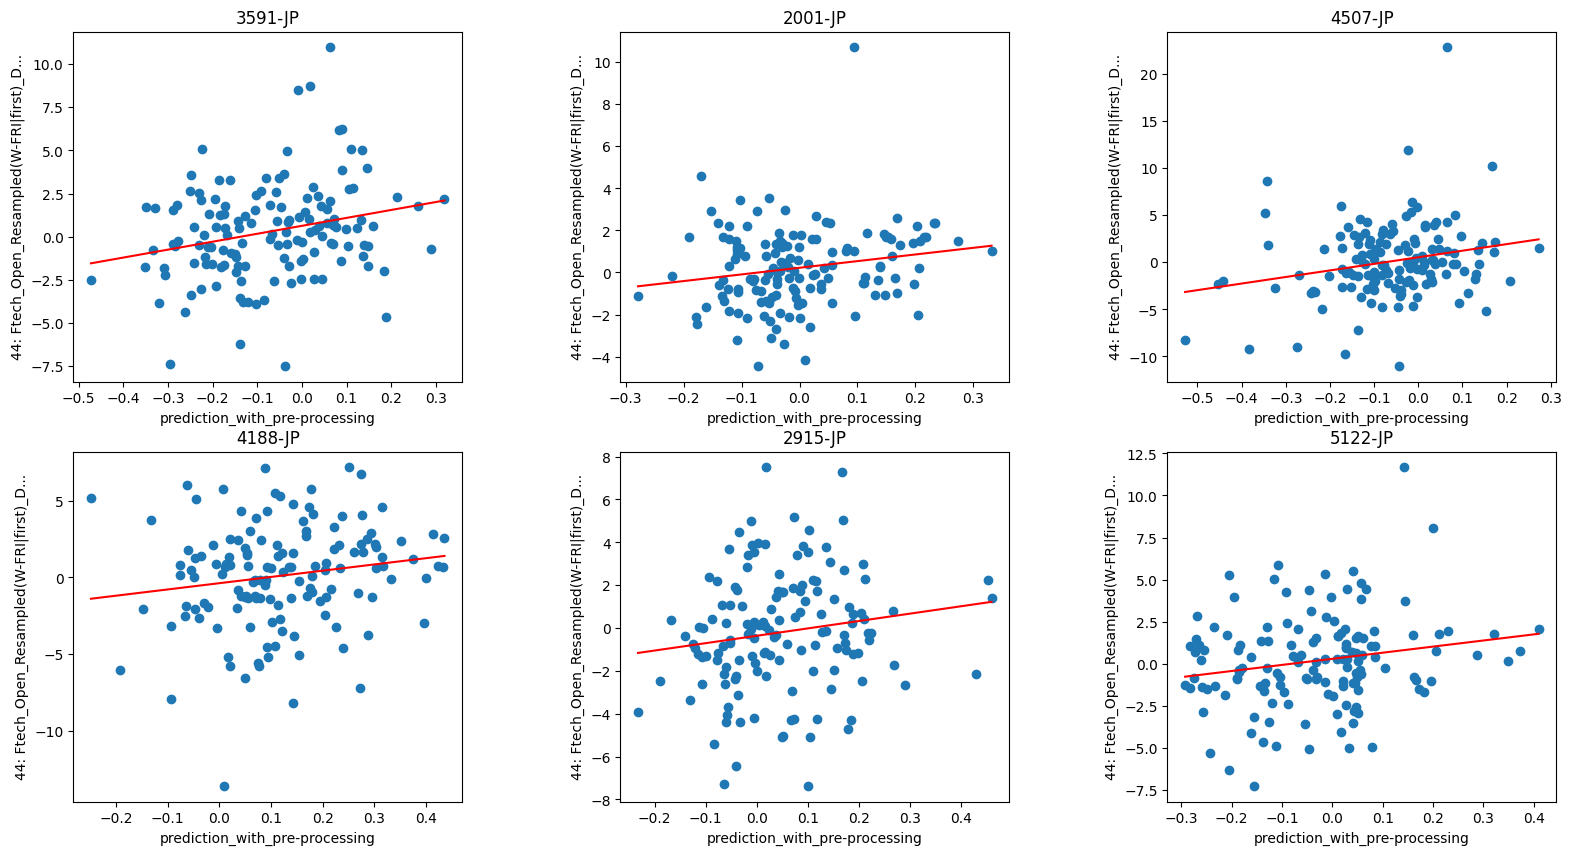

In [23]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values(pred_name, ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=pred_name,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=35,
)

##### Backtesting of predicted results as signals.

In [24]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pred_name,
    open_return,
    nq=3,
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax=None,
    qmin=None,
    swap_long_short=False,
    plot=f'Baseline Prediction-by-[{pred_name}] Backtest'
)

/home/schiba/work/asr_protected/asr_protected/data_manager/transform/generator.py:350: UserWarning:

Differences exist in the y and X feature universe::{'9941-JP', '3004-JP', '8005-JP', '4512-JP', '4925-JP', '2112-JP', '2108-JP', '2917-JP', '2612-JP', '4928-JP', '2117-JP', '7819-JP', '4551-JP', '2930-JP', '2003-JP', '2215-JP', '9852-JP', '2903-JP', '2816-JP', '2293-JP', '9713-JP', '3346-JP', '2224-JP', '2551-JP', '4956-JP', '2901-JP', '2733-JP', '2922-JP', '1380-JP', '2883-JP', '4931-JP', '1384-JP', '2700-JP', '8006-JP', '8041-JP', '4623-JP', '9260-JP', '4558-JP', '2222-JP', '2692-JP', '2218-JP', '2294-JP', '9385-JP', '9950-JP', '4998-JP', '2804-JP', '8030-JP', '2291-JP', '2722-JP', '2872-JP', '2207-JP', '2597-JP', '2819-JP', '6309-JP', '8095-JP', '8228-JP', '4974-JP', '2884-JP', '2009-JP', '3417-JP', '2286-JP', '2926-JP', '2877-JP', '7297-JP', '2204-JP', '2586-JP', '3540-JP', '3306-JP', '2813-JP', '3604-JP', '2217-JP', '2927-JP', '2058-JP', '2876-JP', '2919-JP', '4595-JP'}.Only use un

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-18.475637,-6.930737,11.029993,-0.628354,0.500000,17.530265,-30.860424,-0.224583
#2,5.157753,1.934820,11.537323,0.167701,0.542857,27.745942,-15.522322,0.124648
#3,18.013363,6.757325,12.930091,0.522605,0.578571,18.811960,-17.690653,0.381971
#3-#1,36.489000,13.688063,6.017275,2.274794,0.635714,36.342226,-3.058204,4.475849
#3-#1(cost),36.469624,13.680794,6.017263,2.273591,0.635714,36.342226,-3.059066,4.472213
